## **[Week 11] Convolutional Neural Networks (CNN)**

In this practice session, we will cover the following:
- Revisit the structure of a convolutional layer
- Look over the CIFAR-10 dataset
- Train a CNN model for classification on the CIFAR-10 dataset

**[Important]** \\
The results of exercises should be included in your weekly report for this practice session.
The weekly report for this session should be submitted on KLMS by this friday. No late submission would be accepted.

### 1. Preparations

First, we need to import the required packages

In [ ]:
# Import packages
import torch                                    # PyTorch (an open-source machine-learning library for Python)
import torch.nn as nn                           # Building blocks in PyTorch
import torch.nn.functional as F                 # Functionals in PyTorch
import torch.optim as optim                     # Optimization methods implemented in PyTorch
import numpy as np                              # Tool for mathematical and scientific computations
import random                                   # Generating pesudo-random numbers
import time                                     # Time access
from torch.utils.data import DataLoader         # Wrapper for the easy use of dataset samples
from torchvision import datasets, transforms    # Access to pre-loaded datasets
from matplotlib import pyplot as plt            # Tool for plot and visualization

Let's select the device to use.

- If using a GPU, then the device will be 'cuda'.
- If not using a GPU, then the device will be 'cpu'.

If you want to check whether GPU is available or not, use `torch.cuda.is_available()`.

In [ ]:
# Set PyTorch device (use GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# If GPU is available, check CUDA version
if torch.cuda.is_available():
    !nvcc --version

cuda
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


Let's fix the seed for reproducibility.

In [ ]:
# Set random seeds fixed for reproducibility
seed = 7                    # Do NOT change the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

### 2. Convolutional Layers

In this section, we will recap the concept of convolutional layers.

A convolutional layer consists of multiple filters that locally connects to multi-channel inputs.

For better understanding, we will first consider a case for single-channel inputs and a single filter.

Then, we will extend this to a case for multi-channel inputs and multiple filters.

#### 2-1. Basic

We first start from a case where the input has a single channel like a grayscale image.

Let $\mathbf{x} \in \mathbb{R}^{N \times N}$ be an input, and let $\mathbf{w} \in \mathbb{R}^{k \times k}$ be a ***filter*** (also called as ***kernel*** or ***channel***.)

The $(i, j)$th element of the output $\mathbf{z}$ is defined by

\begin{align}
z_{i,j} = \mathbf{z}(i, j) = \sum_{a=0}^{k-1} \sum_{b=0}^{k-1} \mathbf{x}_{i+a,j+b} \mathbf{w}_{i, j}
\end{align}

The figure below illustrates the mechanism of the convolutional layer.

Unlike multi-layer perceptrons (also called as fully-connected layers), convolutional layers are only connected to local regions of the input.

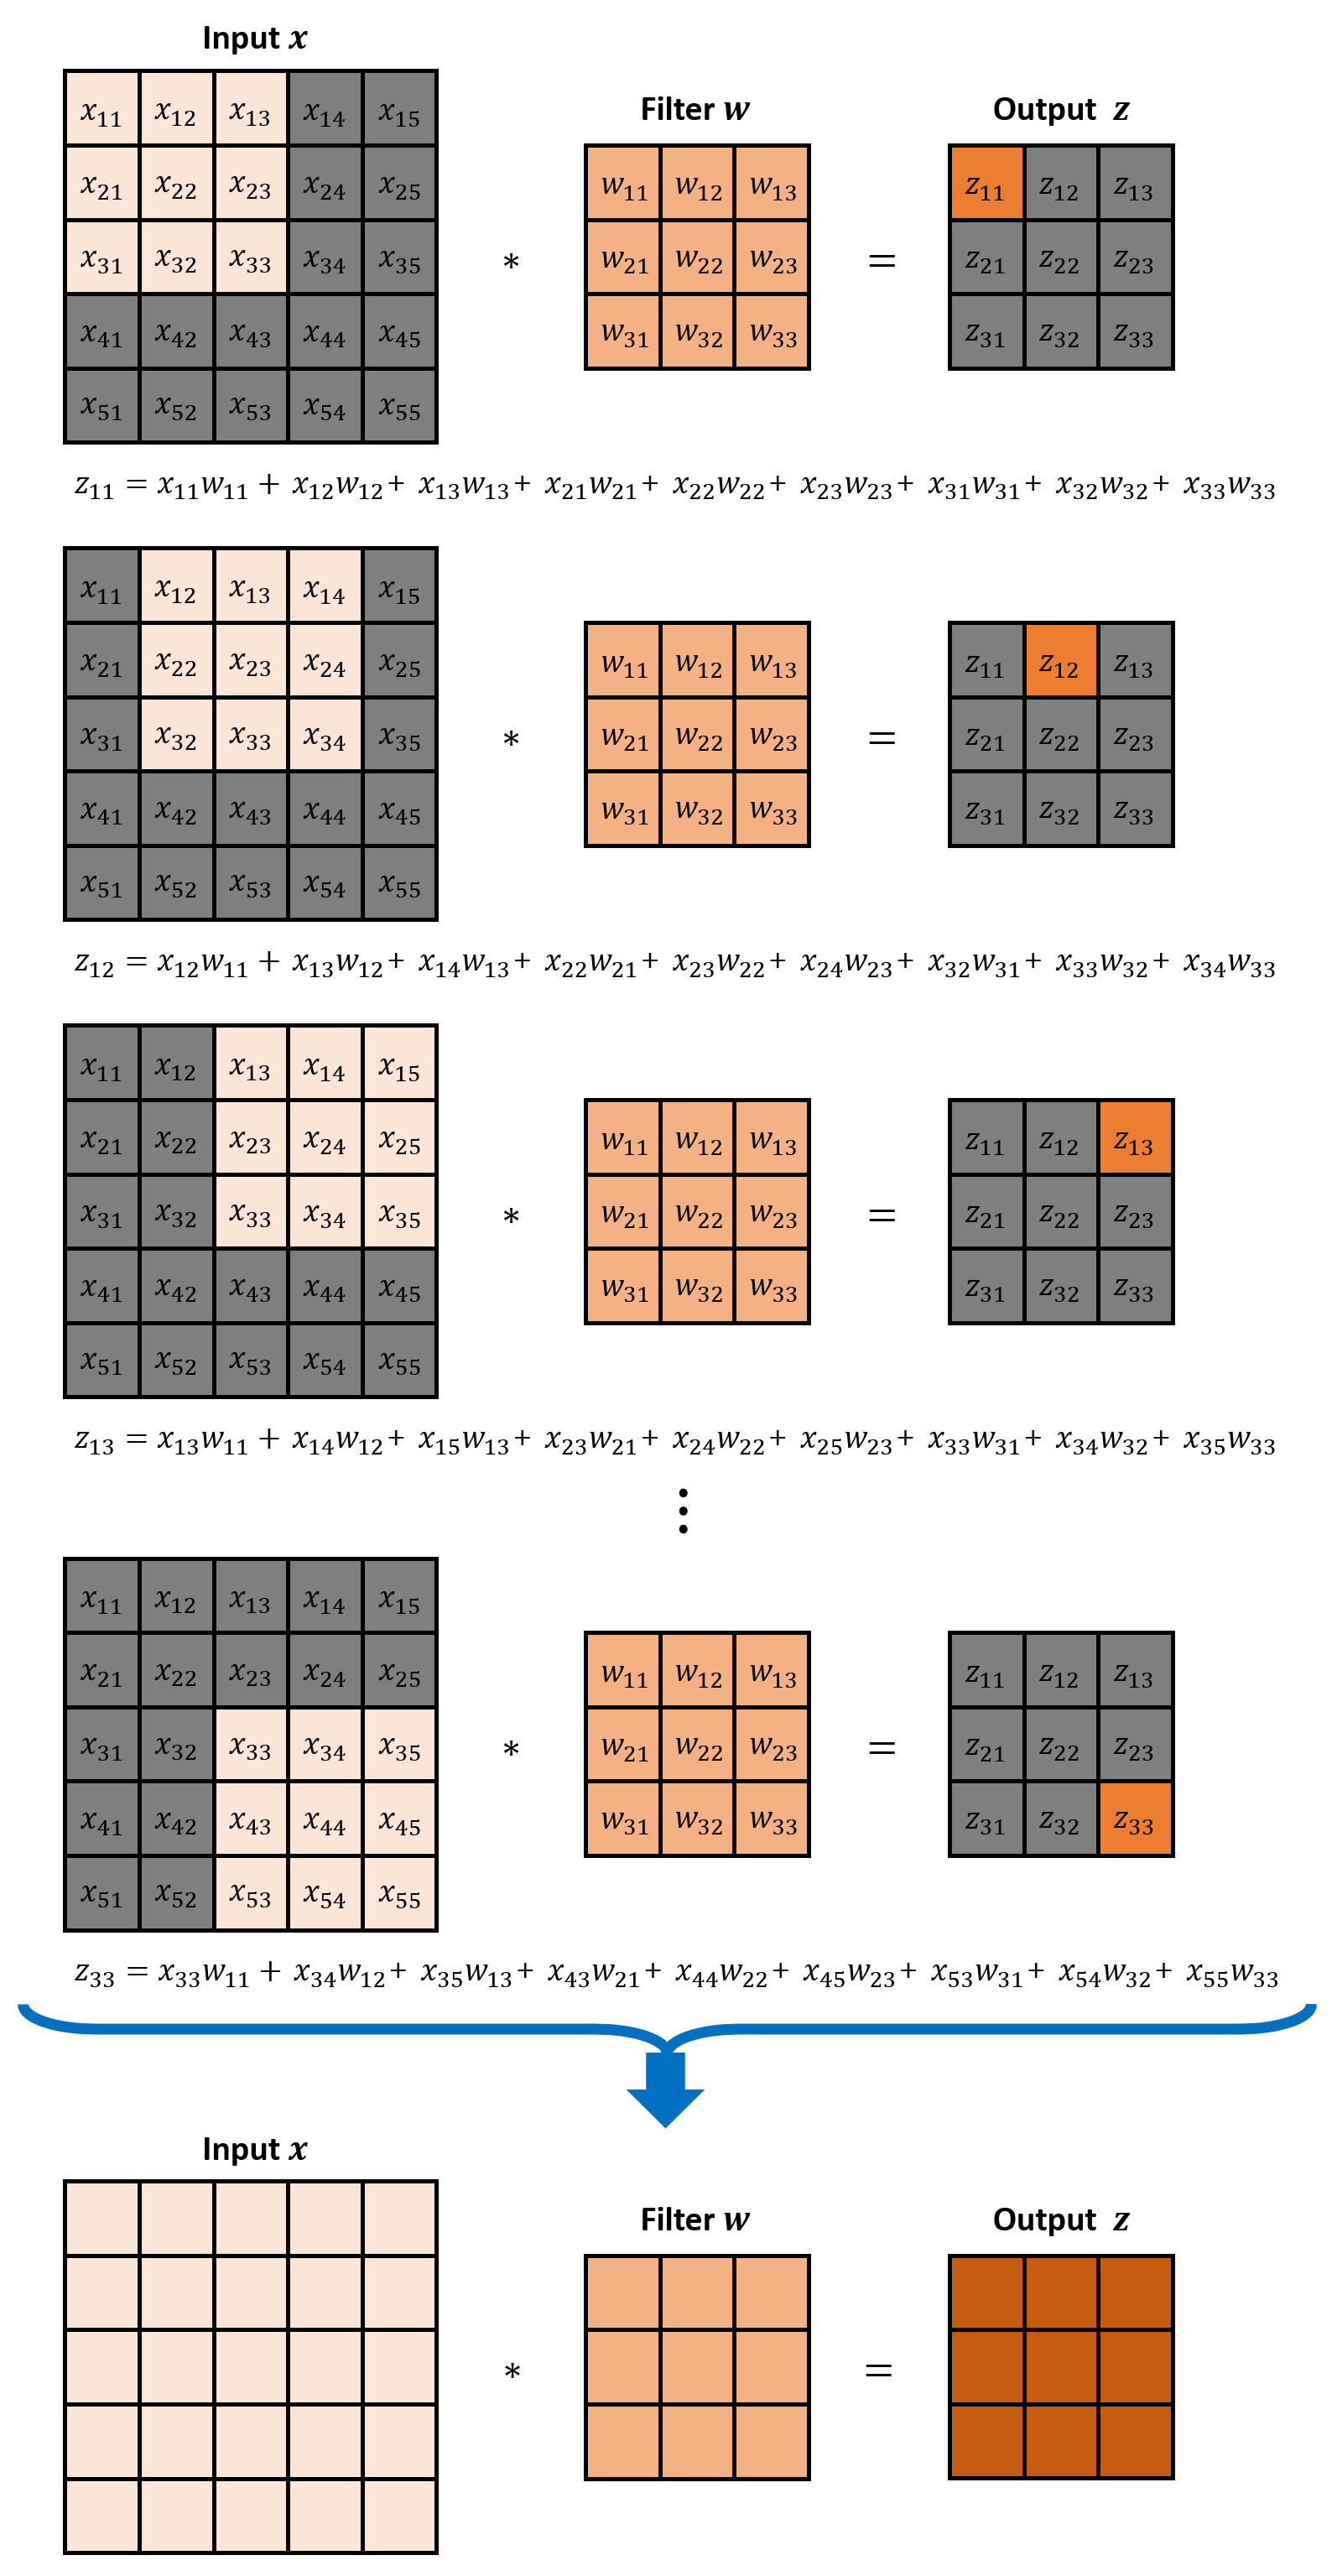

In [ ]:
from IPython.display import Image
Image("figures/cnn_level1.png", width=500)

The following code is an example of using a 2D convolutional layer.

``nn.Conv2d()`` creates a 2D convolutional layer. ``kernel_size=k`` option defines the filter size to $k \times k$.

Note that the width and height of the output shrinks after the convolutional layer.

In [ ]:
# An example of using a 2D convolutional layer with a 3x3 filter (kernel, channel).
x = torch.randn([1, 1, 32, 32])             # Input (shape = (batch_size=1, n_channels=1, width=32, height=32))
conv = nn.Conv2d(1, 1, kernel_size=3)       # 2D Convolutional layer (in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0)
z = conv(x)                                 # Output
print(z.shape)                              # torch.Size([1, 1, 30, 30])

torch.Size([1, 1, 30, 30])


#### 2-2. Stride

We can also increase the ***stride*** to have a downsampled convolution.

Let $\mathbf{x} \in \mathbb{R}^{N \times N}$ be an input, and let $\mathbf{w} \in \mathbb{R}^{k \times k}$ be a filter. Also, let $s \in \mathbb{R}$ be called as stride.

The $(i, j)$th element of the output $\mathbf{z}$ is defined by

\begin{align}
z_{i,j} = \mathbf{z}(i, j) = \sum_{a=0}^{k-1} \sum_{b=0}^{k-1} \mathbf{x}_{(i \times s) +a, (j \times s) + b} \mathbf{w}_{i, j}
\end{align}

Now the "sliding window" is shifted by the stride $s$, so the output is downsampled by $s$.

The figure below illustrates the mechanism of the convolutional layer with stride 2.

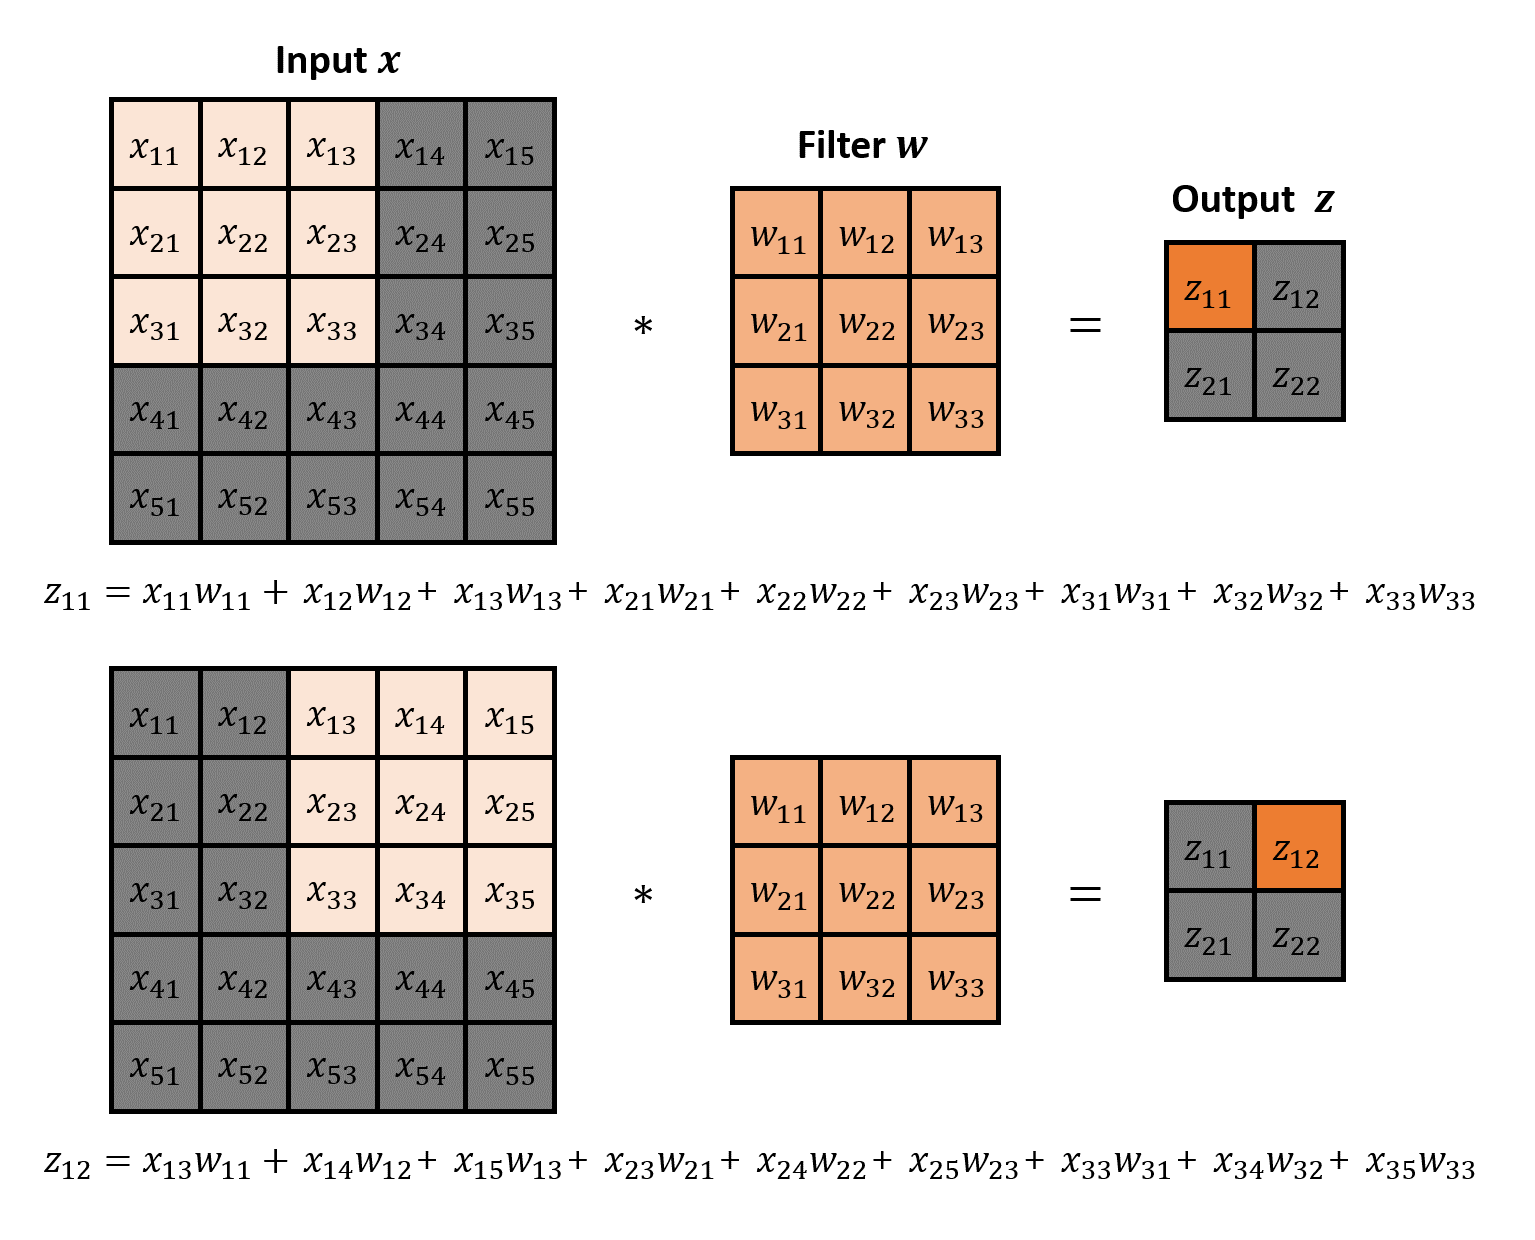

In [ ]:
from IPython.display import Image
Image("figures/stride2.png", width=500)

The following code is an example of using a 2D convolutional layer with stride 2.

The ``stride`` option in ``nn.Conv2d()`` defines the stride of a 2D convolutional layer. The default is ``stride=1``.

You can see the difference in the output size.

In [ ]:
# An example of using a 2D convolutional layer with a 3x3 filter and stride 2.
x = torch.randn([1, 1, 32, 32])                     # Input (shape = (batch_size=1, n_channels=1, width=32, height=32))
conv = nn.Conv2d(1, 1, kernel_size=3, stride=2)     # 2D Convolutional layer (in_channels=1, out_channels=1, kernel_size=3, stride=2, padding=0)
z = conv(x)                                         # Output
print(z.shape)                                      # torch.Size([1, 1, 15, 15])

torch.Size([1, 1, 15, 15])


#### 2-3. Zero-padding

As in the previous section, the output size shrinks after the convolutional layer. However, it is more convenient to control the output size.

Zero-padding expands the input size by adding 0 around the input. Zero-padding allows us to control the spatial size of the output.

The figure below illustrates the mechanism of the zero-padding.

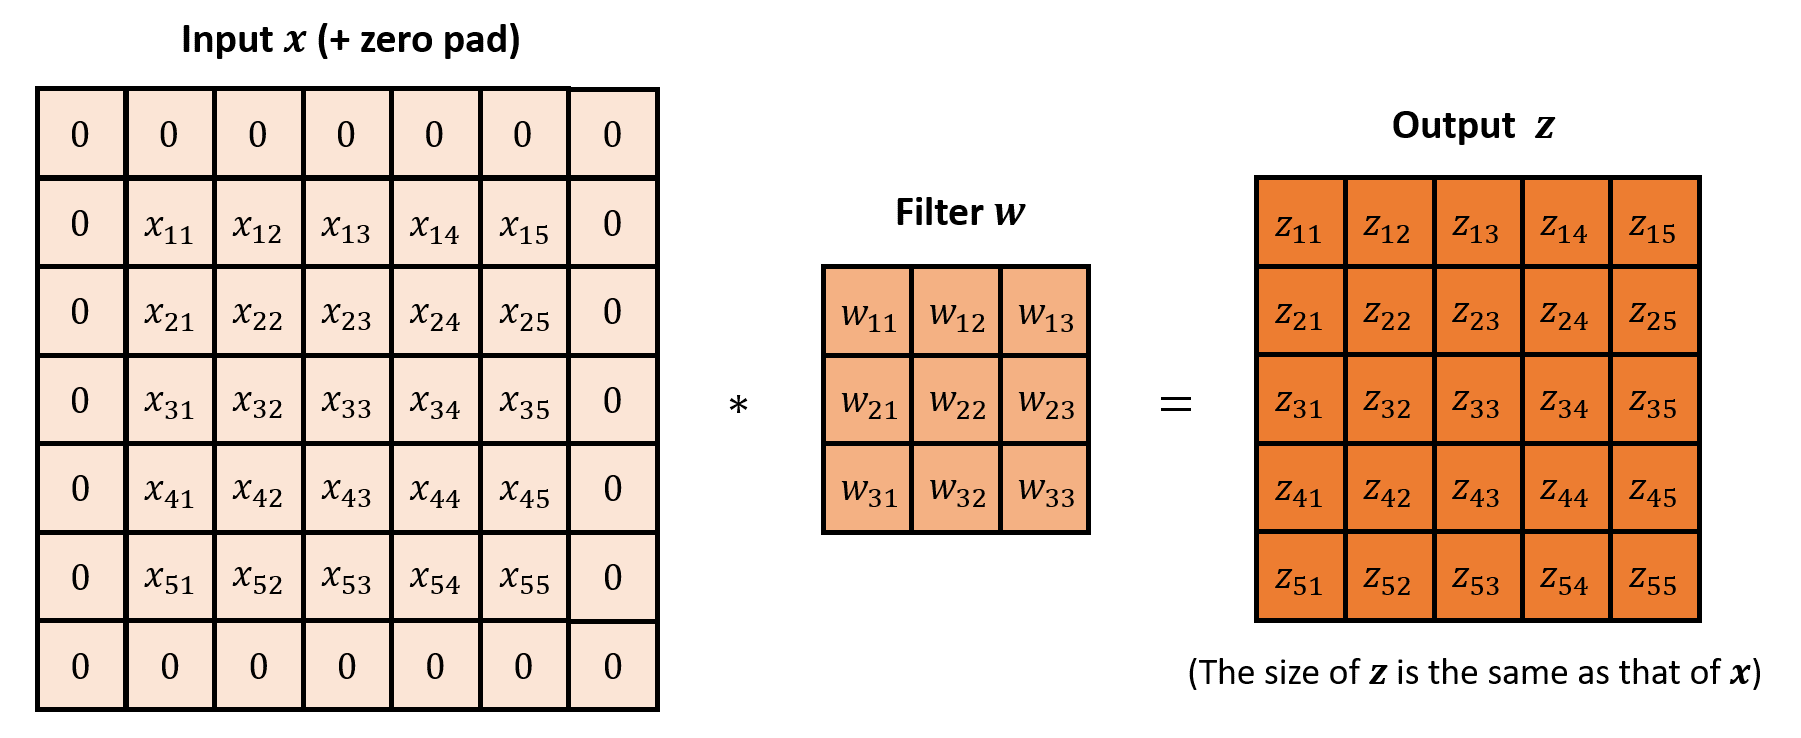

In [ ]:
from IPython.display import Image
Image("figures/zero_padding.png", width=600)

The following code is an example of using a 2D convolutional layer with zero-padding.

You can use the ``padding`` option of ``torch.Conv2d``. There are several options.

- ``padding=n``: convolution with padding with the width of $n$. The default is ``padding=0``.
- ``padding=valid`` : convolution without padding on the input. This is equivalent to ``padding=0``.
- ``padding=same`` : convolution with padding on the input. The output is the same size as the input.

You can see the difference in the output size.

``padding=same`` is useful because we don't have to explicitly compute how much zero-padding is required to preserve the size.

In [ ]:
# An example of using a 2D convolutional layer with and without zero-padding
x = torch.randn([1, 1, 32, 32])                             # Input

# 2D Convolutional layer without zero-padding
conv1 = nn.Conv2d(1, 1, kernel_size=7)                      # default: padding = 0
z1 = conv1(x)
print("conv1 = nn.Conv2d(1, 1, kernel_size=7)")
print(z1.shape)
print()

conv2 = nn.Conv2d(1, 1, kernel_size=7, padding='valid')     # 'valid': no padding (padding = 0)
z2 = conv2(x)
print("conv2 = nn.Conv2d(1, 1, kernel_size=7, padding='valid')")
print(z2.shape)
print()

# 2D Convolutional layer with zero-padding
conv3 = nn.Conv2d(1, 1, kernel_size=7, padding=1)           # padding = 1 : the input is enclosed in 1 pixel thickness of zeros
z3 = conv3(x)
print("conv3 = nn.Conv2d(1, 1, kernel_size=7, padding=1)")
print(z3.shape)
print()

conv4 = nn.Conv2d(1, 1, kernel_size=7, padding='same')      # 'same': padding so that (output size = input size)
z4 = conv4(x)
print("conv4 = nn.Conv2d(1, 1, kernel_size=7, padding='same')")
print(z4.shape)
print()

conv1 = nn.Conv2d(1, 1, kernel_size=7)
torch.Size([1, 1, 26, 26])

conv2 = nn.Conv2d(1, 1, kernel_size=7, padding='valid')
torch.Size([1, 1, 26, 26])

conv3 = nn.Conv2d(1, 1, kernel_size=7, padding=1)
torch.Size([1, 1, 28, 28])

conv4 = nn.Conv2d(1, 1, kernel_size=7, padding='same')
torch.Size([1, 1, 32, 32])



**Exercise 1.** Implement a convolutional layer with a 7x7 kernel and stride 1 so that the output shape matches the input shape.

In [ ]:
# Make the output have the same size as the input.
# - Use a 7x7 kernel with stride 1.
# - Use a scalar value instead of 'same' in the padding option.
x = torch.randn([1, 1, 32, 32])                             # Input (shape = (batch_size=1, n_channels=1, width=32, height=32))

""" ### Implement the code yourself ### """

conv5 = nn.Conv2d(1, 1, kernel_size=7, padding=3)           # equivalent to nn.Conv2d(1, 1, kernel_size=7, padding='same')

""" ################################### """

z5 = conv5(x)
print(z5.shape)     # This should be torch.Size([1, 1, 32, 32])

torch.Size([1, 1, 32, 32])


#### 2-4. Extension to multi-channel Inputs

In reality, the input has multiple channels. For example, an RGB image has 3 channels (Red, Green, Blue). In this case, the depth of the filter matches the number of channels of the input.

Let $\mathbf{x} \in \mathbb{R}^{C_{in} \times N \times N}$ be an input, and let $\mathbf{w} \in \mathbb{R}^{C_{in} \times k \times k}$ be a filter. (Here $C_{in}$ is the number of channels of the input)

The $(i, j)$th element of the output $\mathbf{z}$ is defined by

\begin{align}
z_{i,j} = \mathbf{z}(i, j) = \sum_{c=0}^{C_{in}-1} \sum_{a=0}^{k-1} \sum_{b=0}^{k-1} \mathbf{x}_{c, i+a,j+b} \mathbf{w}_{c, i, j}
\end{align}

For convenience, let's assume that the stride is 1 and zero-padding is applied to the input.

The figure below illustrates the mechanism of the convolutional layer with a three-dimensional input.

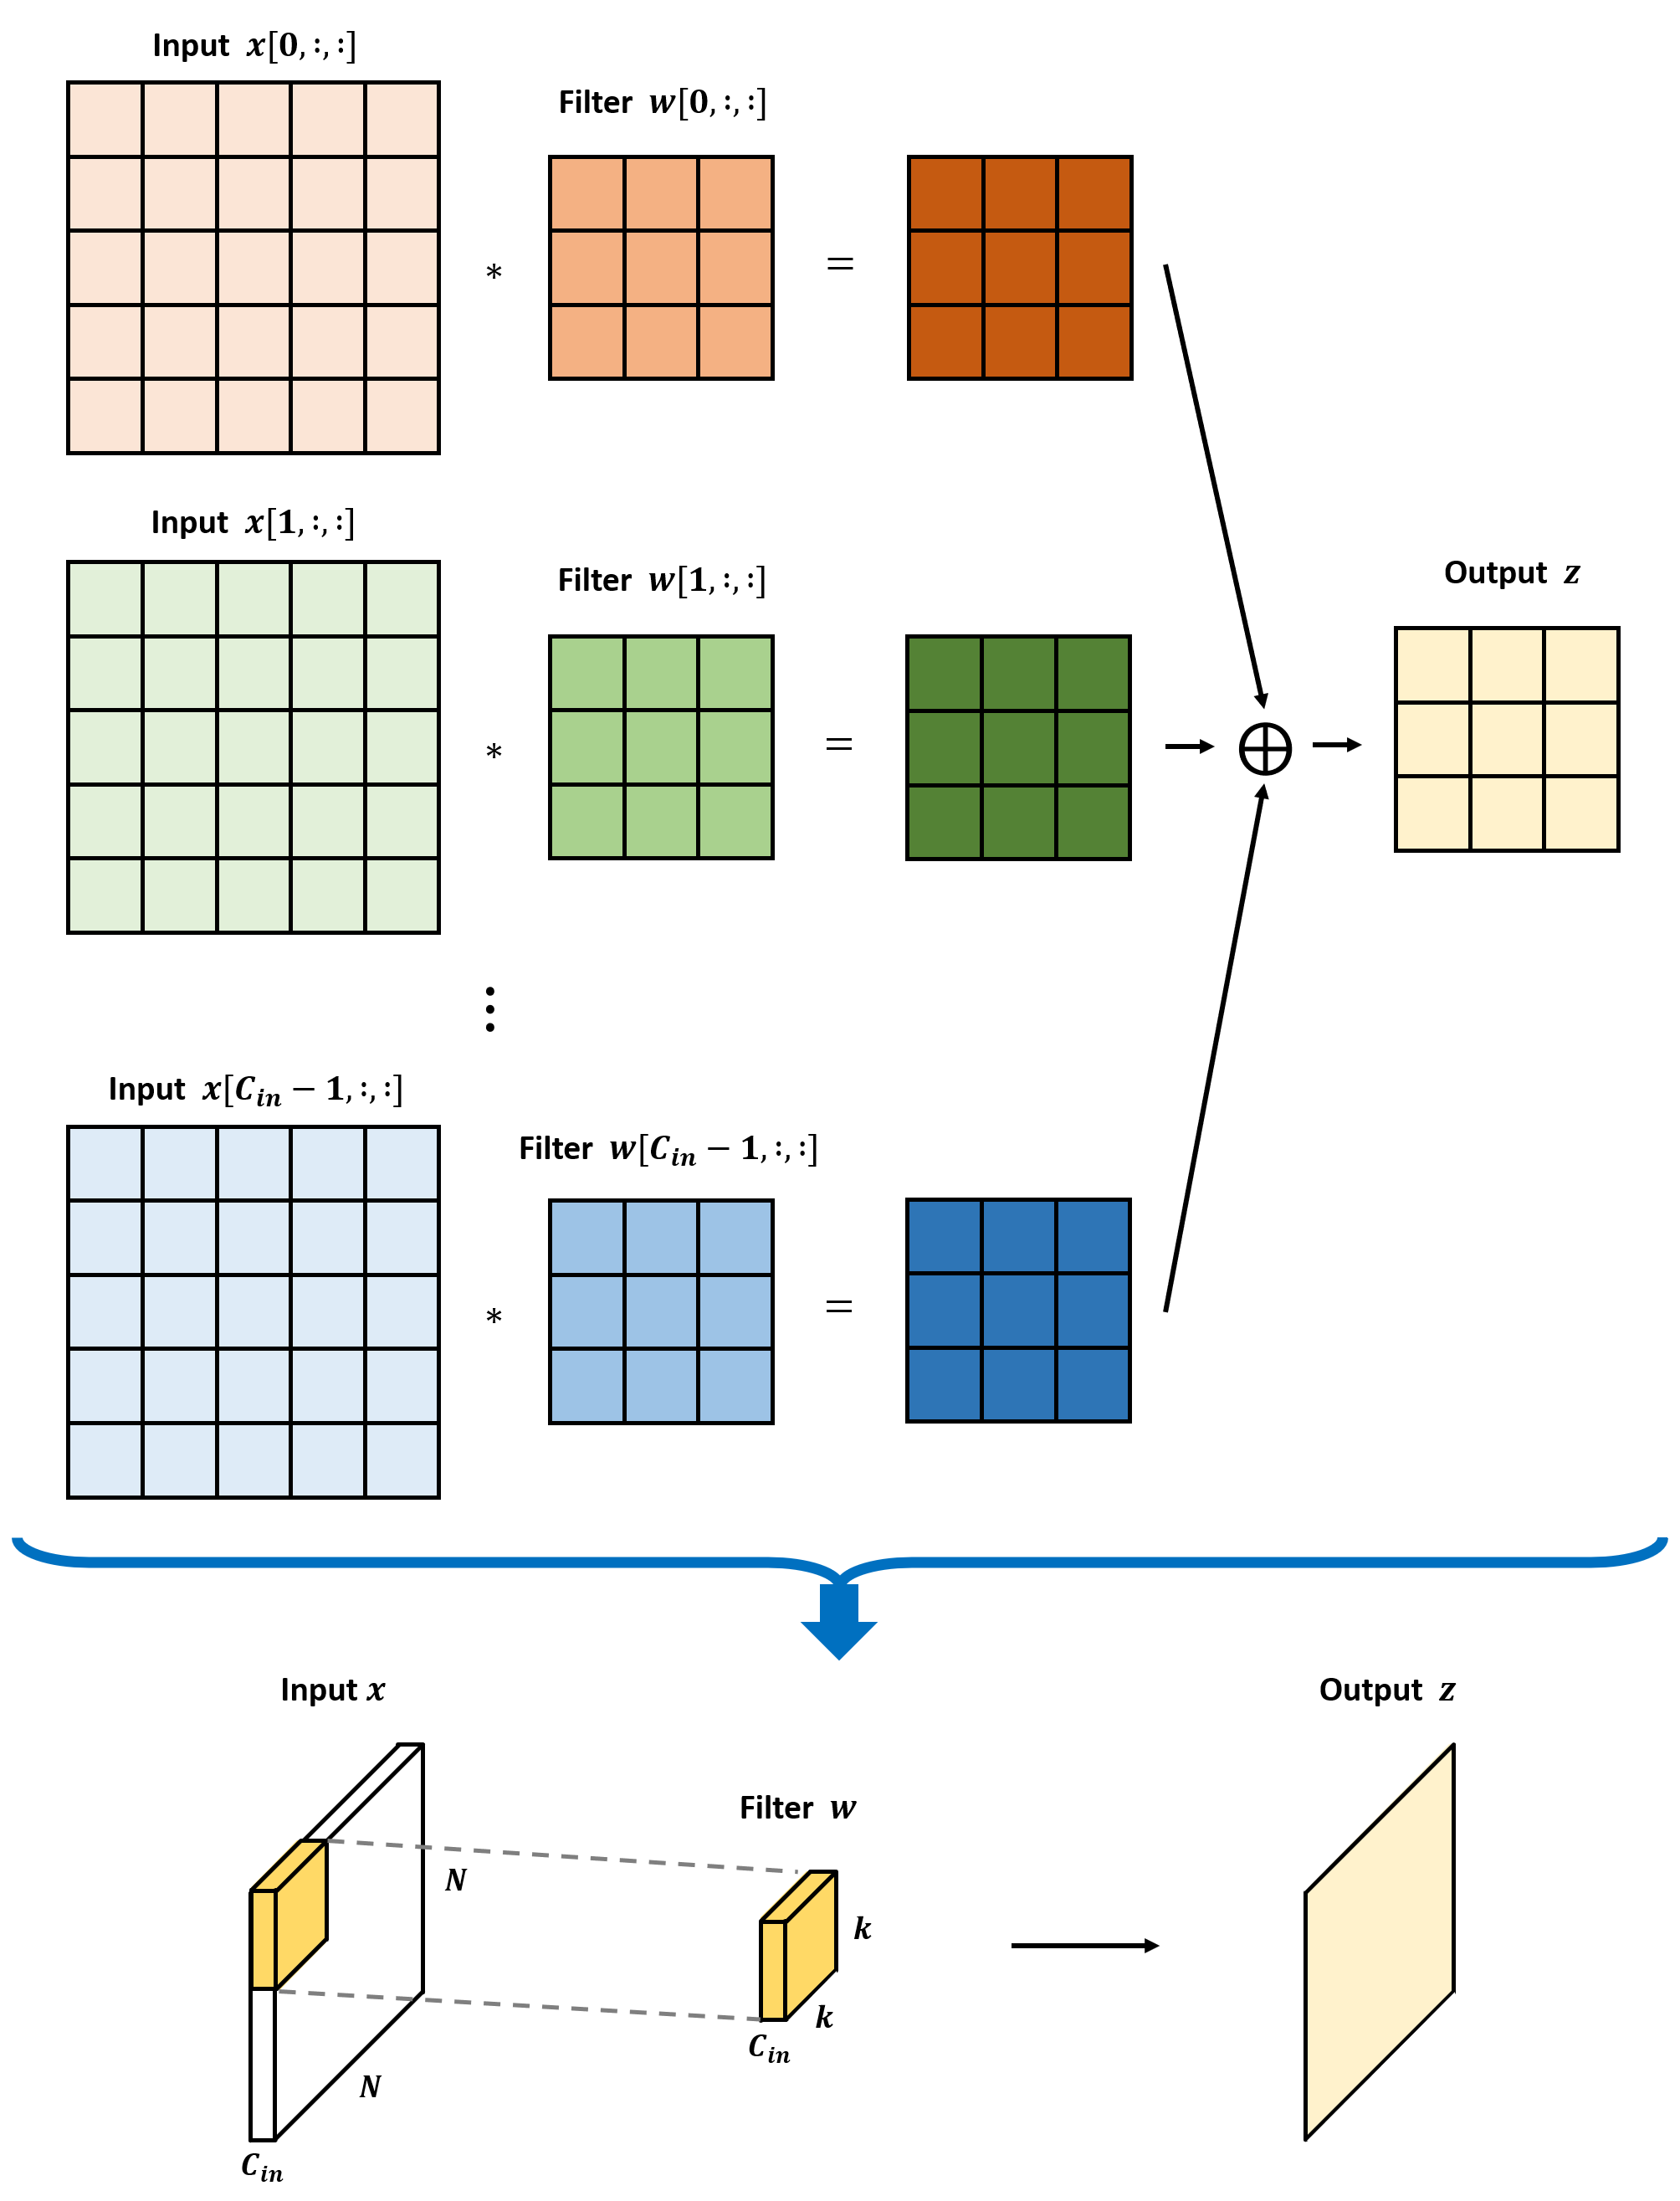

In [ ]:
from IPython.display import Image
Image("figures/cnn_level2.png", width=600)

The following code is an example of using a 2D convolutional layer processing a 3D input.

Note that the ``in_channels`` option in ``nn.Conv2d`` matches the number of channels of the input.

In [ ]:
# An example of processing a 3D input (ex. RGB image)
x = torch.randn([1, 3, 32, 32])                         # Input (shape = (batch_size=1, n_channels=3, width=32, height=32))
conv = nn.Conv2d(3, 1, kernel_size=3, padding='same')   # 2D Convolutional layer (in_channels=3, out_channels=1, kernel_size=3, stride=1, padding='same')
z = conv(x)                                             # Output
print(z.shape)                                          # torch.Size([1, 1, 32, 32])

torch.Size([1, 1, 32, 32])


***Important Note***.

In PyTorch, a set of images is expressed as a 4-dimensional NCWH tensor with shape ``(N, C, W, H) = (batch_size, n_channels, width, height)``.

However, some other packages (e.g. TensorFlow) use a different ordering ``(N, W, H, C) = (batch_size, width, height, n_channels)``.

So, always check the order of the input dimensions.

#### 2-5. Extension to Multiple Filters

So, far we considered a single filter. A filter represents some characteristics of the inputs.

However, a single filter is not sufficient to express enough characteristics of the inputs.

Therefore, a convolutional layer consists of multiple filters so that each filter is encouraged to capture different characteristics of the inputs.

The figure below illustrates the mechanism of the convolutional layer with multiple filters.

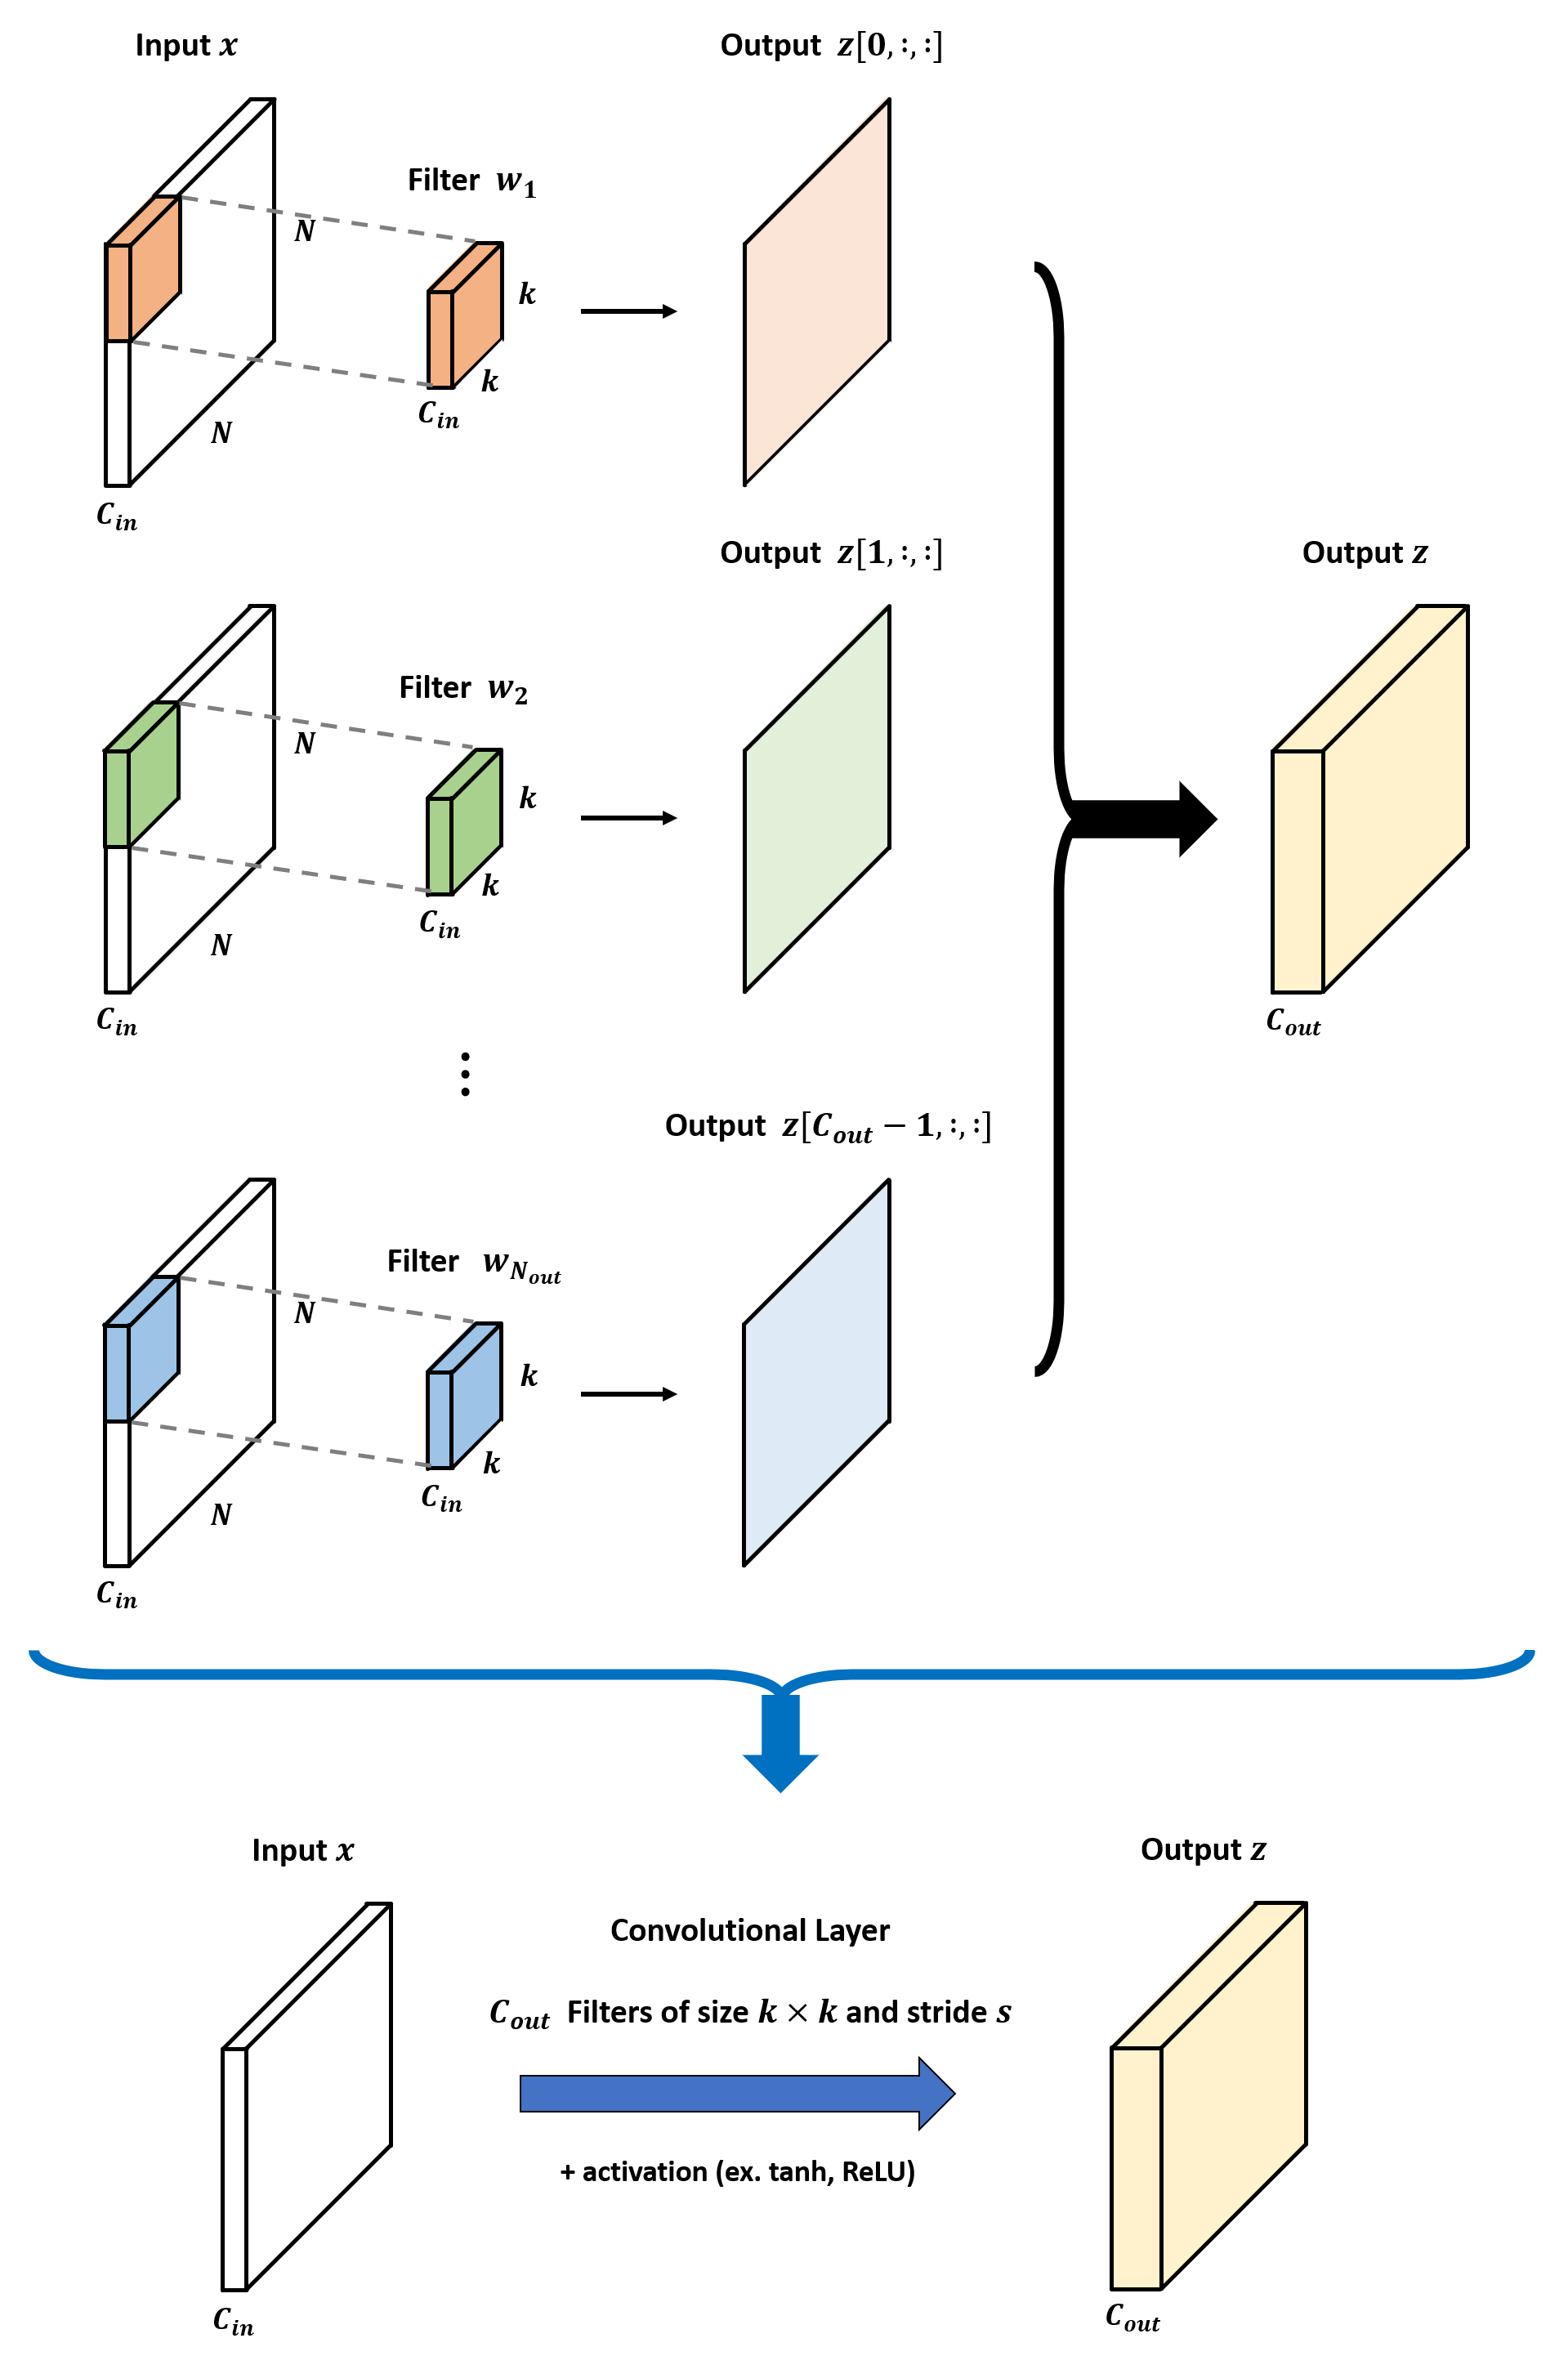

In [ ]:
from IPython.display import Image
Image("figures/cnn_level3.png", width=600)

The following code is an example of using a 2D convolutional layer with multiple filters.

Note that the the number of channels of the output matches the ``out_channel`` option of ``nn.Conv2d``.

In [ ]:
# An example of using a 2D convolutional layer with multiple filters
x = torch.randn([1, 3, 32, 32])                             # Input (shape = (batch_size=1, n_channels=3, width=32, height=32))
conv = nn.Conv2d(3, 16, kernel_size=3, padding='same')      # 2D Convolutional layer (in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
z = conv(x)                                                 # Output
print(z.shape)                                              # torch.Size([1, 16, 32, 32])

torch.Size([1, 16, 32, 32])


### 3. Pooling, Dropout, and Batch Normalization

In this section, we will recap the concepts of pooling, dropout, and batch normalization.

#### 3-1. Pooling

Pooling summarises the local region of outputs.

Similar to strides in a convolutional layer, pooling reduces the computation complexity. Usually either "stride > 1" or "pooling" is used.

The most common pooling operation is max-pooling, where the largest value among the local regions is selected.

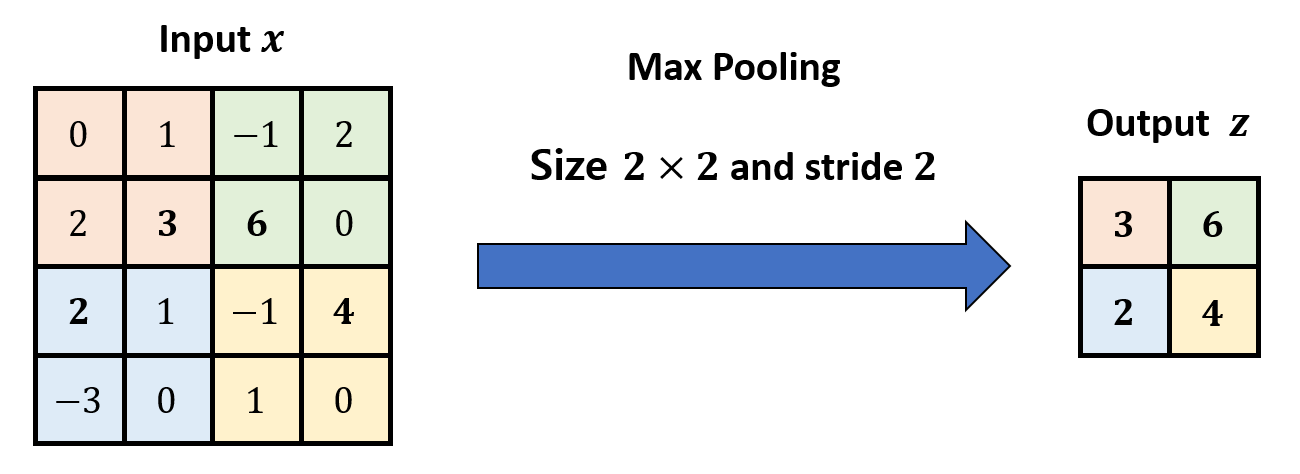

In [ ]:
from IPython.display import Image
Image("figures/max_pooling.png", width=500)

The following code is an example of using a max-pooling layer. ``nn.MaxPool2d`` creates a max-pooling layer.

In [ ]:
# An example of processing a 3D input (ex. RGB image)
x = torch.Tensor([[[
    [ 0,  1,  -1, 2],
    [ 2,  3,  6,  0],
    [ 2,  1,  -1, 4],
    [-3,  0,  1,  0],
]]])    # Input (shape = (batch_size=1, n_channels=1, width=4, height=4))

max_pool = nn.MaxPool2d(kernel_size=2)  # Max-pooling (size 2x2 and stride 2)
z = max_pool(x)                         # Output

print("z:")
print(z)
print()
print("z.shape:")
print(z.shape)

z:
tensor([[[[3., 6.],
          [2., 4.]]]])

z.shape:
torch.Size([1, 1, 2, 2])


#### 3-2. Dropout

Dropout randomly deactivates (=zeroes the value) the hidden unit with some probability.

Dropout can prevent the model from overfitting to the training dataset.

The following code is an example of using a dropout. ``nn.Dropout`` creates a dropout layer.

- During training, dropout layers are activated and the output is scaled by $1 / (1-p)$.
- During the evaluation, dropout layers are inactivated.

In [ ]:
# Dropout Example
x = torch.Tensor([[[
    [ 0,  1,  -1, 2],
    [ 2,  3,  6,  0],
    [ 2,  1,  -1, 4],
    [-3,  0,  1,  0],
]]])    # Input (shape = (batch_size=1, n_channels=1, width=4, height=4))
print("Input:")
print(x)
print()

dropout = nn.Dropout(p=0.2)              # Randomly deactivate each unit with probability p=0.2

# Training Mode
dropout.train()
z1 = dropout(x)                          # Output during training. Output is scaled by 1/(1-0.2) = 1.25
print("During Training:")
print(z1)
print()

# Evaluation Mode
dropout.eval()
z2 = dropout(x)                          # Output during evaluation
print("During Evaluation:")
print(z2)

Input:
tensor([[[[ 0.,  1., -1.,  2.],
          [ 2.,  3.,  6.,  0.],
          [ 2.,  1., -1.,  4.],
          [-3.,  0.,  1.,  0.]]]])

During Training:
tensor([[[[ 0.0000,  1.2500, -1.2500,  2.5000],
          [ 0.0000,  3.7500,  7.5000,  0.0000],
          [ 2.5000,  0.0000, -1.2500,  5.0000],
          [-3.7500,  0.0000,  1.2500,  0.0000]]]])

During Evaluation:
tensor([[[[ 0.,  1., -1.,  2.],
          [ 2.,  3.,  6.,  0.],
          [ 2.,  1., -1.,  4.],
          [-3.,  0.,  1.,  0.]]]])


#### 3-3. Batch Normalization

Batch Normalization normalizes the outputs over the minibatch.

To maintain the expressive power of the network, the normalized units are scaled and shifted by learnable parameters $\gamma$ and $\beta$.

The batch normalization layer typically operates along the channel dimension, so the dimensions of $\gamma$ and $\beta$ is the number of channel of the input. In detail, for each channels of the input, the mean and variance are computed across the width and height dimensions.

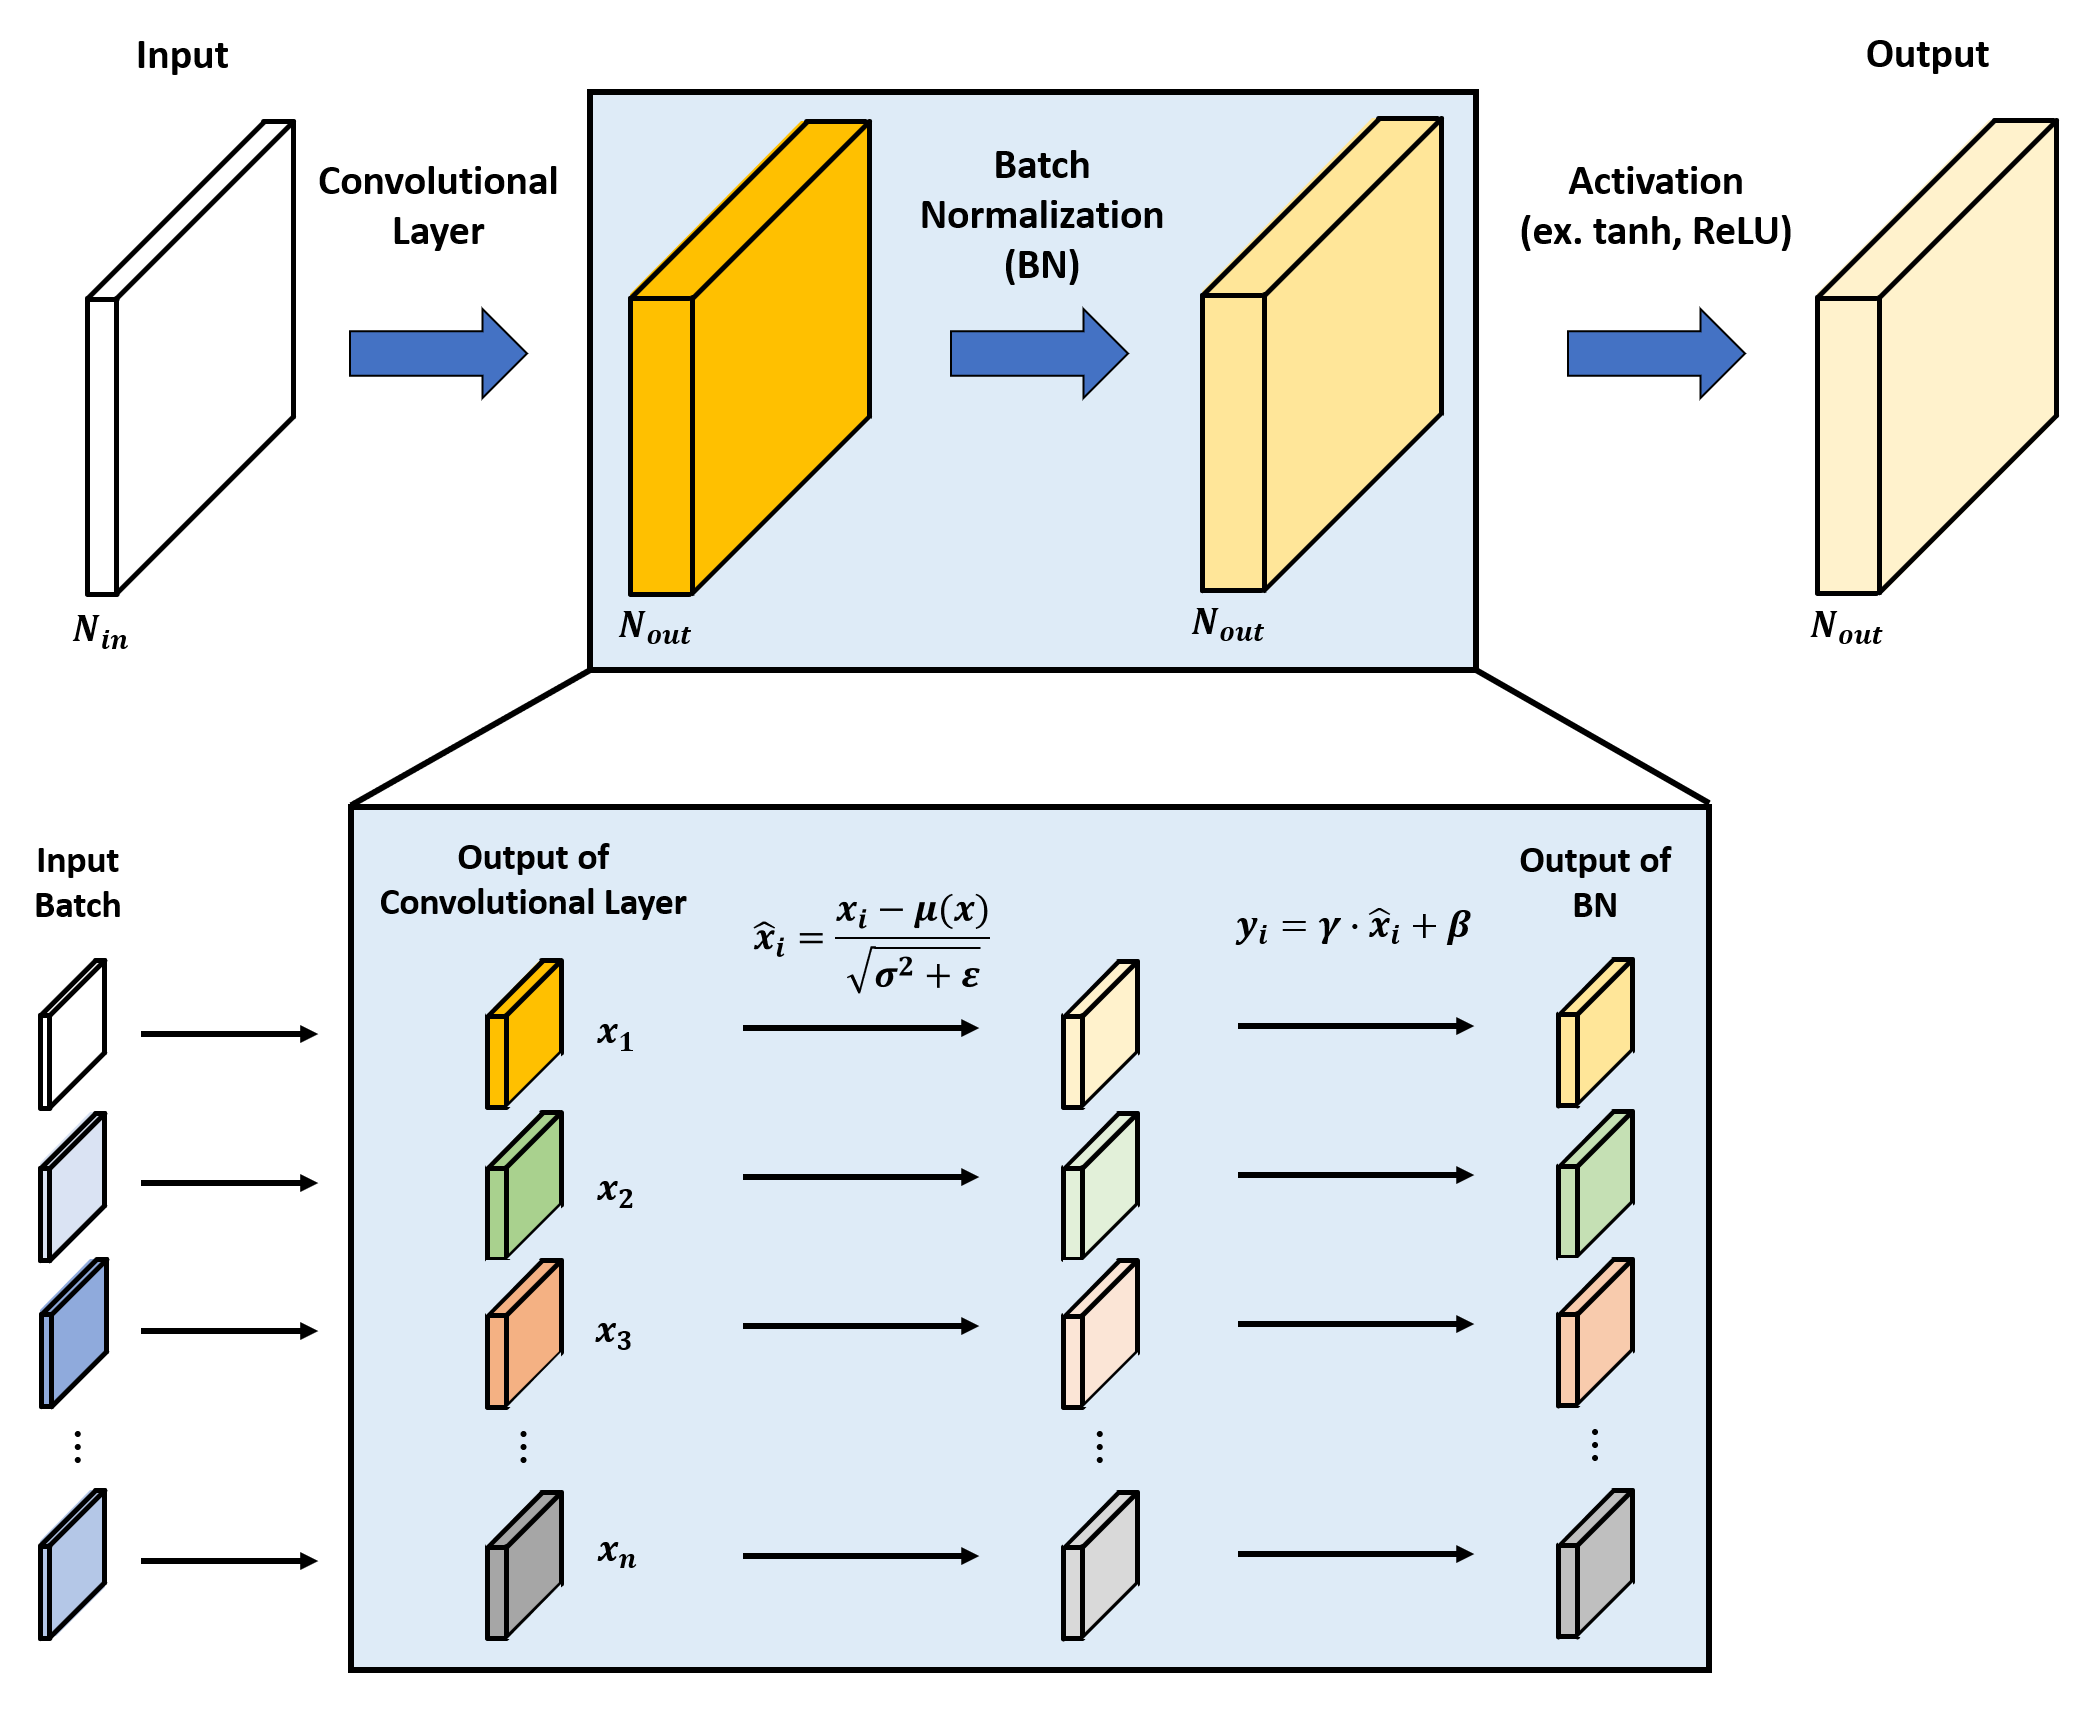

In [ ]:
from IPython.display import Image
Image("figures/batch_normalization.png", width=800)

The following code is an example of using a batch normalization. ``nn.BatchNorm2d`` creates a batch normalization layer.

In [ ]:
# Batch Normalization Example
x = torch.Tensor([
    [[
    [ 1,  1,  1,],
    [ 1,  1,  1,],
    [ 1,  1,  1,],
    ]],
    [[
    [ 2,  2,  2,],
    [ 2,  2,  2,],
    [ 2,  2,  2,],
    ]],
    [[
    [ 3,  3,  3,],
    [ 3,  3,  3,],
    [ 3,  3,  3,],
    ]],
    ])      # Input (shape = (batch_size=3, n_channels=1, width=3, height=3))

print("Input Mean:")
print(x.mean())
print()

print("Input Std:")
print(x.std())
print()

batch_norm = nn.BatchNorm2d(num_features=1)             # Batch Normalization. num_features is the number of channels.
print("BatchNorm2d Layer:")
print(batch_norm)
print()

print("Weight:")
print(batch_norm.weight)    # Initialized to ones
print("Bias:")
print(batch_norm.bias)      # Initialized to zeros
print()

z1 = batch_norm(x)          # Output
print("Output:")
print(z1)
print()

print("Output Mean:")
print(z1.mean())
print()

print("Output Std:")
print(z1.std())
print()


Input Mean:
tensor(2.)

Input Std:
tensor(0.8321)

BatchNorm2d Layer:
BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Weight:
Parameter containing:
tensor([1.], requires_grad=True)
Bias:
Parameter containing:
tensor([0.], requires_grad=True)

Output:
tensor([[[[-1.2247, -1.2247, -1.2247],
          [-1.2247, -1.2247, -1.2247],
          [-1.2247, -1.2247, -1.2247]]],


        [[[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[ 1.2247,  1.2247,  1.2247],
          [ 1.2247,  1.2247,  1.2247],
          [ 1.2247,  1.2247,  1.2247]]]], grad_fn=<NativeBatchNormBackward0>)

Output Mean:
tensor(-4.4152e-09, grad_fn=<MeanBackward0>)

Output Std:
tensor(1.0190, grad_fn=<StdBackward0>)



#### 3-4. Ordering Layers

In general, most people use the following order when implementing a block of layers in CNN:

1\. Convolutional layer

2\. Batch normalization

3\. Activation (ex. ReLU)

4\. Max-pooling

5\. Dropout

Notes:
- Batch normalization and dropout are optional. They are known to be effective in large models.
- Max-pooling is optional. Multiple strides ($s > 1$) can be used instead.
- Some people prefer reversing the order between Max-pooling and Dropout.

### 4. CIFAR-10 Dataset

In this section, we will look into the **CIFAR-10 (Canadian Institute for Advanced Research, 10 classes)** dataset.

CIFAR-10 is a database of hand-written digits, which consists of 50,000 samples for training and 10,000 samples for evaluation.

Each sample consists of a RGB image of size 32x32 and a scalar label (0-9) indicating the class. So there are 10 classes. The list of classes are the following:
- airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The objective is to train the model to predict the class of the input.

In [ ]:
# CIFAR-10 Datasets
cifar10_train = datasets.CIFAR10("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar10_test = datasets.CIFAR10("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar10_train, cifar10_val = torch.utils.data.random_split(cifar10_train, [45000, 5000])

# Dataloaders
dataloaders = {}
dataloaders['train'] = DataLoader(cifar10_train, batch_size=128, shuffle=True, drop_last=True)
dataloaders['val'] = DataLoader(cifar10_test, batch_size=128, shuffle=False, drop_last=True)
dataloaders['test'] = DataLoader(cifar10_train, batch_size=128, shuffle=False, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


Let's visualize some CIFAR-10 samples.

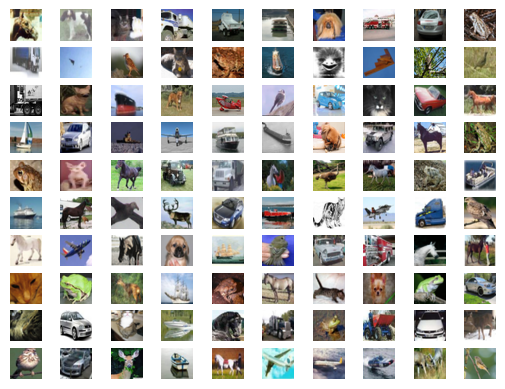

In [ ]:
# Visualize CIFAR-10 samples
import cv2
for i in range(100):
    index = random.randint(0, 45000)
    x_sample, _ = cifar10_train[index]
    x_sample = torch.permute(x_sample,(1,2,0)).numpy()
    plt.subplot(10, 10, i+1)
    plt.imshow(x_sample)
    plt.axis('off')

### 5. Classification via CNN

In this section, we will train a CNN model for classification on the CIFAR-10 dataset.

#### 5-1. Define a classifier with CNN

Now we define a CNN classification model.

This model consists of the following layers:
- a convolutional layer ``conv1`` with 16 filters of size 3x3, followed by ReLU activation ``activ`` and max-pooling ``max_pooling``,
- a convolutional layer ``conv2`` with 32 filters of size 3x3, followed by ReLU activation ``activ`` and max-pooling ``max_pooling``, and
- a linear layer ``linear`` without activations.

Here, both convolutional layers have stride 1, and zero-padding is applied so that the output width and height matches the input width and height. Batch normalization and dropout are omitted because we are using a very simple model.

**Exercise 2.** Implement ``conv1``, ``conv2``, ``activ``, ``max_pooling``, and ``linear``, and implment the forward process of the model.

In [ ]:
# Define model
class CNNClassificationModel(nn.Module):
    def __init__(self):
        super(CNNClassificationModel, self).__init__()

        """ ### Implement the code yourself ### """

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding='same')   # conv. layer 1 (out_channels = 16, kernel_size = 3, stride = 1, with zero_padding)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')  # conv. layer 2 (out_channels = 32, kernel_size = 3, stride = 1, with zero_padding)
        self.activ = nn.ReLU()                                         # Activation (ReLU)
        self.max_pooling = nn.MaxPool2d(kernel_size=2)                 # Max-pooling (kernel_size = 2)
        self.linear = nn.Linear(32*8*8,10)                             # Linear layer (use nn.Linear(). what are the numbers of in_features and out_features?)

        """ ################################### """

    def forward(self, x):

        """ ### Implement the code yourself ### """

        out = self.conv1(x)            # conv. layer 1
        out = self.activ(out)          # activation
        out = self.max_pooling(out)    # max-pooling

        out = self.conv2(out)          # conv. layer 2
        out = self.activ(out)          # activation
        out = self.max_pooling(out)    # max-poolin

        out = out.reshape(128,-1)      # Reshape the output to shape (batch_size, n_channels * width * height)
        out = self.linear(out)         # Linear layer

        """ ################################### """

        return out

model = CNNClassificationModel().to(device)

#### 5-2. Define a loss function

We will use cross-entropy as a loss function.

In [ ]:
# Define a loss function
loss_function = nn.CrossEntropyLoss()

#### 5-3. Define an optimizer

We will use Adam (derived from the name "Adaptive Moment estimation") as an optimization method.

In [ ]:
# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### 5-4. Train the classifier

Now we are ready to train the classifier.

In [ ]:
# Train the classifier
total_train_epochs = 20             # The number of training epochs

start_time = time.time()            # To measure wall-clock time for training
average_loss_list_cnn = []          # To record average training losses

# Training loop
for epoch in range(total_train_epochs):
    average_loss = 0.0
    steps = 0

    # Each iteration
    for n, data in enumerate(dataloaders['train'], 0):
        x, y_true = data                                    # x = input, y_true = label
        x = x.to(device)                                    # Flattening the input
        y_true = y_true.to(device)
        y_pred = model(x)                                   # y_pred = output of the model
        loss = loss_function(input=y_pred, target=y_true)   # Compute loss

        optimizer.zero_grad()                               # Delete previously computed gradients
        loss.backward()                                     # Compute the gradients by backpropagation
        optimizer.step()                                    # Update the parameters of the model using the gradients

        average_loss += loss.item()
        steps += 1

    # Print average loss
    print("Epoch: {:3d} | Iter: {:3d} | Average Loss: {:5.3f} | Elapsed Time: {:6.1f} s".format(
        epoch + 1, n+1, average_loss / steps, time.time()-start_time)
    )
    average_loss_list_cnn.append(average_loss / steps)
    average_loss = 0.0
    steps = 0

    # Validation
    total = 0
    correct = 0
    model.eval()
    with torch.no_grad():                                   # No gradeint computation
        for data in dataloaders['val']:
            x, y_true = data
            x = x.to(device)
            y_true = y_true.to(device)
            y_pred = model(x)
            loss = loss_function(input=y_pred, target=y_true)
            y_pred_argmax = torch.max(y_pred, dim=1)        # y_pred_argmax = predicted label. Choose the index with the highest output value.

            total += y_true.size(0)                                     # total number of prediction
            correct += (y_pred_argmax.indices == y_true).sum().item()   # correct prediction
    model.train()

    # Print validation accuracy
    print('Epoch: {:3d} | Validation Accuracy: {:5.3f} %'.format(epoch + 1, correct / total * 100))
    print()

Epoch:   1 | Iter: 351 | Average Loss: 1.668 | Elapsed Time:    7.0 s
Epoch:   1 | Validation Accuracy: 49.339 %

Epoch:   2 | Iter: 351 | Average Loss: 1.348 | Elapsed Time:   15.7 s
Epoch:   2 | Validation Accuracy: 55.389 %

Epoch:   3 | Iter: 351 | Average Loss: 1.231 | Elapsed Time:   24.6 s
Epoch:   3 | Validation Accuracy: 57.061 %

Epoch:   4 | Iter: 351 | Average Loss: 1.154 | Elapsed Time:   34.0 s
Epoch:   4 | Validation Accuracy: 59.175 %

Epoch:   5 | Iter: 351 | Average Loss: 1.103 | Elapsed Time:   42.2 s
Epoch:   5 | Validation Accuracy: 61.288 %

Epoch:   6 | Iter: 351 | Average Loss: 1.060 | Elapsed Time:   51.1 s
Epoch:   6 | Validation Accuracy: 62.410 %

Epoch:   7 | Iter: 351 | Average Loss: 1.019 | Elapsed Time:   60.0 s
Epoch:   7 | Validation Accuracy: 62.710 %

Epoch:   8 | Iter: 351 | Average Loss: 0.986 | Elapsed Time:   69.4 s
Epoch:   8 | Validation Accuracy: 64.032 %

Epoch:   9 | Iter: 351 | Average Loss: 0.963 | Elapsed Time:   77.7 s
Epoch:   9 | Valid

#### 5-5. Test the trained classifier

Let's evaluate the trained model on the test dataset.

In [ ]:
# Test the model
total = 0
correct = 0

model.eval()
with torch.no_grad():                                   # No gradient computation
    for data in dataloaders['test']:
        x, y_true = data
        x = x.to(device)
        y_true = y_true.to(device)
        y_pred = model(x)
        loss = loss_function(input=y_pred, target=y_true)
        y_pred_argmax = torch.max(y_pred, dim=1)        # y_pred_argmax = predicted label. Choose the index with the highest output value.

        total += y_true.size(0)                                     # total number of prediction
        correct += (y_pred_argmax.indices == y_true).sum().item()   # correct prediction

# Print test accuracy
print('Test Accuracy: {:5.3f} %'.format(correct / total * 100))

Test Accuracy: 73.226 %


#### 5-6. Comparing training losses

Let's plot the average training loss.

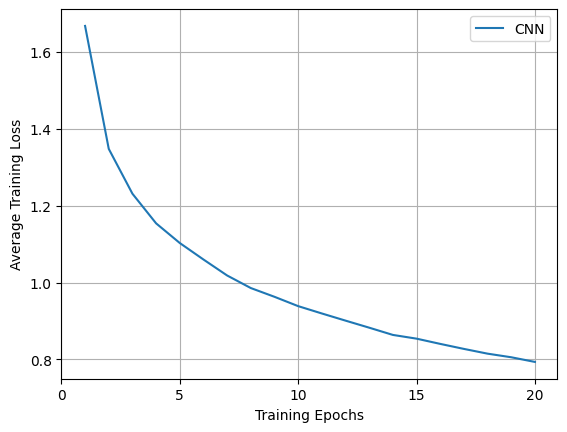

In [ ]:
# Plot training loss for each epoch
epoch_list = [i+1 for i in range(20)]
plt.plot(epoch_list, average_loss_list_cnn, label='CNN')
plt.xlabel('Training Epochs')
plt.ylabel('Average Training Loss')
plt.xticks([0, 5, 10 ,15, 20])
plt.grid(visible=True)
plt.legend()

### References

- https://cs231n.github.io/convolutional-networks/
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://github.com/deeplearningzerotoall/PyTorch/blob/master/lab-10_1_mnist_cnn.ipynb
- KAIST AI504: Programming for Artificial Intelligence, Practice Sessions by Prof. Edward Yoonjae Choi